# Micro- (and hopefully soon geo-) Founded Occupational Mobility Network

*Setup from @rmaria del rio-chanona et al. 2021*
*Code: @ebbamark


In [1]:
# Import packages
import numpy as np
import pandas as pd
import random as random
import matplotlib.pyplot as plt
import math as math
from IPython import display
rng = np.random.default_rng()

path = "~/Documents/Documents - Nuff-Malham/GitHub/transition_abm/"

## Setup

In [2]:
# Make global decision as to which data to initialise network on. Current options are "toy" or "USA"

init = "toy"
# init = "USA"
# behav = False
shock = True


### Data

#### Toy Model
Toy model constructed on 5 fake occupations with pre-determined employment, unemployment, vacancies, target demand, and wages.

In [3]:
# Import information about relevant files to employment/unemployment, target demand, vacancies, etc.
if init == "toy":
    A = pd.read_csv(path+"data/small_adj_full.csv", delimiter=';', decimal=',', header=None)
    employment = pd.read_csv(path+"data/employed.csv", header = None)
    unemployment = pd.read_csv(path+"data/unemployed.csv", header = None)
    vacancies = pd.read_csv(path+"data/vacancies.csv", header = None)
    demand_target = pd.read_csv(path+"data/target_demand.csv")
    wages = pd.DataFrame(np.round(np.random.normal(50000, 10000, 5)), columns = ['Wages'])
    mod_data =  {"A": A, "employment": employment, 
                 'unemployment':unemployment, 'vacancies':vacancies, 
                 'demand_target': demand_target, 'wages': wages}



#### US Model
Model constructed using 464 occupations from US Bureau of Labor Statistics Data and IPUMS.
Data input from replicaiton code in dRC et al 2021: https://zenodo.org/records/4453162


In [4]:
if init == "USA":
    A = pd.read_csv(path+"dRC_Replication/data/occupational_mobility_network.csv", header=None)
    employment = round(pd.read_csv(path+"dRC_Replication/data/ipums_employment_2016.csv", header = 0).iloc[:, [4]]/1000)
    # Crude approximation using avg unemployment rate of ~5% - should aim for occupation-specific unemployment rates
    unemployment = round(employment*(0.05/0.95))
    # Less crude approximation using avg vacancy rate - should still aim for occupation-specific vacancy rates
    vac_rate_base = pd.read_csv(path+"dRC_Replication/data/vacancy_rateDec2000.csv").iloc[:, 2].mean()/100
    vacancies = round(employment*vac_rate_base/(1-vac_rate_base))
    # Needs input data...
    demand_target = employment + vacancies
    wages = pd.read_csv(path+"dRC_Replication/data/ipums_variables.csv")[['median_earnings']]
    mod_data =  {"A": A, "employment": employment, 
                 'unemployment':unemployment, 'vacancies':vacancies, 
                 'demand_target': demand_target, 'wages': wages}
    


### Agents and Classes

One function and three classes are defined:
- (Function) Utility/decision-making function used by workers when deciding which vacancies to apply to.
- (Class) Worker: individual worker has state-specific attributes (whether or not employed, current or latest held occupation, time employed or unemployed, current or latest wage held, whether or not they have been hired in a particular time step) and character-specific attributes (occupational history, risk aversion score (not yet implemented) and an impatience score (not yet used)). Worker has one function which is to search and apply for a vacancy.
- (Class) Occupation has an id, list of workers currently employed in that occupation, list of neighboring occupations based on transition adjacency matrix (imperfect solution), current and target demand for labour, list of applicants to open vacancies, and wage). Occupation has two internal functions (1) to separate workers and (2) to update all workers in an occupation after each time step.
- (Class) Vacancy has an occupational id, list of applicants (duplicated above in occupation class...to fix), and a wage (duplicated above in occupation class...to fix). Vacancy has one internal function to hire an applicant.

In [5]:
## Defining functions
# Ranking utility/decision-making function
def util(w_current, w_offered, skill_sim):
    # No longer scale by impatience
    # return 1/(1+(math.exp(-impatience_factor*((w_offered-(w_current*(1-skill_sim)))/10000))))
    return 1/(1+(math.exp(-((w_offered-(w_current*(1-skill_sim)))/10000))))

# Simple quadratic for now in which a worker increase search effort for a period of 6 time steps (ie. months) 
# unemployed after which a worker begins to become discouraged. 
# This follows definition from the US BLS and Pew Research Centre
def search_effort(t_unemp):
    return round(20/((t_unemp-6)**2 + 1)) + 1

## Defining classes
# Potentially redundant use of IDs in the below classes...to check
class worker:
    def __init__(wrkr, occupation_id, employed, longterm_unemp, time_employed,
                 time_unemployed, wage, hired, list_of_occs, risk_av_score):
        # State-specific attributes:
        # Occupation id
        wrkr.occupation_id = occupation_id
        # Binary variable for whether employed or not
        wrkr.employed = employed
        # Binary variable for whether long-term unemployed
        wrkr.longterm_unemp = longterm_unemp
        # Number of time steps employed
        wrkr.time_employed = time_employed
        # Number of time steps unemployed (perhaps redundant with above)
        # Used as criteria for impatience
        wrkr.time_unemployed = time_unemployed
        # Worker wage
        # Could be used as additional criteria for impatience...
        wrkr.wage = wage
        # Whether the worker has been hired in this time step - reset to zero at the end of every time step
        # Used as protective attribute in hiring process (ie. cannot be hired twice)
        wrkr.hired = hired
        
        # Character-specific attributes:
        # Employment history, list of occupations previously held
        # NOT YET USED
        wrkr.emp_history = list_of_occs
        # Identity score - to be defined...
        # wrkr.identity = identity_score
        # Risk aversion: Stefi suggested to use number of 
        # occupations previously held as proxy ie. len(emp_history)
        # Currently takes a value 0-9 indicating at which index of utility ranked vacancies to start sampling/slicing
        wrkr.risk_aversion = risk_av_score
    
    def search_and_apply(wrkr, net, vac_list, beh):
        # A sample of relevant vacancies are found that are in neighboring occupations
        # Will need to add a qualifier in case sample is greater than available relevant vacancies
        # ^^ have added qualifier...bad form to reassign list?
        rel_vacs = [vac for vac in vac_list if net[wrkr.occupation_id].list_of_neigh_bool[vac.occupation_id]]
        if beh:
            rel_vacs = random.sample(rel_vacs, min(len(rel_vacs), 30))
            # Sort found relevant vacancies by utility-function defined above and apply to amount dictated by impatience
            for v in sorted(rel_vacs, key = lambda v: util(wrkr.wage, v.wage,net[wrkr.occupation_id].list_of_neigh_weights[v.occupation_id]), reverse = True)[slice(wrkr.risk_aversion, wrkr.risk_aversion + search_effort(wrkr.time_unemployed))]:
                # Introduce randomness here...binomial?
                v.applicants.append(wrkr)
        else:
            rel_vacs = random.sample(rel_vacs, min(len(rel_vacs), search_effort(wrkr.time_unemployed)))
            for r in rel_vacs:
                r.applicants.append(wrkr)
            
class occupation:
    def __init__(occ, occupation_id, list_of_workers, list_of_neigh_bool, 
                 list_of_neigh_weights, current_demand, 
                 target_demand, applicants, wage):
        occ.occupation_id = occupation_id
        occ.list_of_workers = list_of_workers
        occ.list_of_neigh_bool = list_of_neigh_bool
        occ.list_of_neigh_weights = list_of_neigh_weights
        occ.current_demand = current_demand
        occ.target_demand = target_demand
        occ.applicants = applicants
        occ.wage = wage
    
    def separate_workers(occ):
        if(len(occ.list_of_workers) != 0):
            sep_prob = delta_u + gamma * max(0, occ.current_demand - occ.target_demand)/sum(wrkr.employed for wrkr in occ.list_of_workers)
            emp = [el for el in occ.list_of_workers if el.employed]
            sep_counter = 0
            for w in random.sample(emp, np.random.binomial(len(emp), sep_prob)):
                w.employed = False
                w.longterm_unemp = False
                w.time_employed = 0
                w.time_unemployed = 0
                sep_counter += 1
    
    def update_workers(occ):
        for w in occ.list_of_workers:
            # Must update hired attribute of workers
            w.hired = False
            if w.employed:
                w.time_employed += 1
            if not(w.employed):
                w.time_unemployed += 1
                w.longterm_unemp = True if w.time_unemployed >= 7 else False
                #don’t w.search_effort = search_effort(w.time_unemployed)
                
        
class vac:
    def __init__(v, occupation_id, applicants, wage):
        v.occupation_id = occupation_id
        v.applicants = applicants
        v.wage = wage
    def hire(v, net):
        a = random.choice([app for app in v.applicants if not(app.hired)])
        assert(not(a.employed))
        assert(not(a.hired))
        net[v.occupation_id].list_of_workers.append(net[a.occupation_id].list_of_workers.pop(net[a.occupation_id].list_of_workers.index(a)))
        a.occupation_id = v.occupation_id
        a.employed = True
        a.longterm_unemp = False
        a.time_employed = 0
        a.time_unemployed = 0
        a.wage = v.wage
        a.emp_history.append(v.occupation_id)
        a.hired = True
        # Reset?
        # wrkr.risk_aversion = risk_av_score
        # Reset?
        # wrkr.impatience = impatience_score
        v.applicants.clear()
        
        

### Initialise Network

In [6]:
### Function and condition to initialise network

def initialise(n_occ, employment, unemployment, vacancies, demand_target, A, wages):
    """ Makes a list of occupations with initial conditions
       Args:
           n_occ: number of occupations initialised
           employment: vector with employment of each occupation
           unemployment: vector with unemployment of each occupation
           vacancies: vector with vacancies of each occupation
           demand_target: vector with (initial) target_demand for each occupation (never updated)
           A: adjacency matrix of network (not including auto-transition probability)
           wages: vector of wages of each occupation

       Returns:
            occupations: list of occupations with above attributes
            vacancies: list of vacancies with occupation id, wage, and list of applicants
       """
    occs = []
    vac_list = []
    ids = 0
    for i in range(0, n_occ):
        # appending relevant number of vacancies to economy-wide vacancy list
        for v in range(round(vacancies.iat[i,0])):
            vac_list.append(vac(i, [], wages.iat[i,0]))
            
        occ = occupation(i, [], A[i] > 0, A[i],
                         (employment.iat[i,0] + vacancies.iat[i,0]), 
                         demand_target.iat[i,0], [], wages.iat[i,0])
        # creating the workers of occupation i and attaching to occupation
        ## adding employed workers
        for e in range(round(employment.iat[i,0])):
            # Assume they have all at least 1 t.s. of employment
            occ.list_of_workers.append(worker(occ.occupation_id, True, False, 1, 0, wages.iat[i,0], False, [occ.occupation_id], random.randint(0, 9)))
            ## adding unemployed workers
            # Could consider adding random initial unemployment durations...for now no one becomes longterm unemployed until 6 time steps in
        for u in range(round(unemployment.iat[i,0])):
            # Assigns time unemployed from absolute value of normal distribution....
            occ.list_of_workers.append(worker(occ.occupation_id, False, False, 0, abs(int(np.random.normal(0, 2))), wages.iat[i,0], False,
                                                     [occ.occupation_id], 
                                                      random.randint(0, 9)))
        occs.append(occ)
        ids += 1
    return occs, vac_list
    

In [7]:
###################################
# INITIAL MODEL CONDITIONS ########
###################################
if init == "toy":
    T = 250
    delta_u = 0.045
    delta_v = 0.04
    gamma_u = gamma_v = gamma = 0.01
    
if init == "USA":
    T = 50
    delta_u = 0.02
    delta_v = 0.02
    gamma_u = gamma_v = gamma = 0.03



In [8]:
####################
# Testing Cell #####
####################

## Model Run
### Function

In [9]:
####################
# Model Run ########
####################
def run_sim(behav_spec, data, time_steps, runs):
    # Records variables of interest
    record = pd.DataFrame(columns=['Sim', 'Time', 'Occupation_ID', 'Workers', 'Employment', 'Unemployment', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand'])
    print(record)
    for run in range(runs):
        print("Running ", init, " model.")
        print("RUN: ", run)
        # Initialise occupational mobility network
        net_temp, vacs = initialise(len(data['A']), data['employment'], data['unemployment'], data['vacancies'], data['demand_target'], data['A'], data['wages'])
        for t in range(time_steps):
            print("TIME: ", t)
            if t == 50 and shock:
                print("initiatied shock!")
                net_temp[0].target_demand += 25
                net_temp[1].target_demand += 50
                net_temp[2].target_demand += 50
                net_temp[3].target_demand += 50
                net_temp[4].target_demand = 100

            # Ensure number of workers in economy has not changed
            assert(sum(map(lambda x: len(x.list_of_workers), net_temp)) == employment.sum().item() + unemployment.sum().item())
            for occ in net_temp:

                ### SEPARATIONS
                occ.separate_workers()

                # Ensure that separated workers have been reassigned appropriately 
                # (ie. that people move witihin the same occupation from employed to unemployed 
                # and that the total number of workers iwthin an occupation is (at this stage) 
                # the same as before separations
                if t > 0:
                    temp = record.loc[(record['Sim'] == run) & (record['Occupation_ID'] == occ.occupation_id) & (record['Time'] == t-1)]
                    assert(temp.Employment.item() - sum(wrkr.employed for wrkr in occ.list_of_workers) ==
                           sum(not(wrkr.employed) for wrkr in occ.list_of_workers) - temp.Unemployment.item())
                    assert(len(occ.list_of_workers) == temp.Workers.item())

                ### APPLICATIONS
                # Questions to verify:
                # - CANNOT be fired and apply in same time step ie. time_unemployed > 0
                # - CAN be rejected and apply in the same time step - no protected attribute
                unemp = [el for el in occ.list_of_workers if not(el.employed) and el.time_unemployed > 0]
                for u in unemp:
                    u.search_and_apply(net_temp, vacs, behav_spec)

            ### HIRING
            # Ordering of hiring randomised to ensure list order does not matter in filling vacancies...
            # ....might be better to do this using an unordered set?
            for v_open in sorted(vacs,key=lambda _: random.random()):
                # Removes any applicants that have already been hired in another vacancy
                v_open.applicants[:] = [app for app in v_open.applicants if not(app.hired)]
                if len([app for app in v_open.applicants if not(app.hired)]) > 0:
                    v_open.hire(net_temp)
                    vacs.remove(v_open)
                    assert(len(v_open.applicants) == 0)
                else:
                    pass

            ### OPEN VACANCIES
            # Update vacancies after all shifts have taken place
            # Could consider making this a function of the class itself
            for occ in net_temp:
                # Update all workers
                occ.update_workers()
                emp = sum(wrkr.employed for wrkr in occ.list_of_workers)
                occ.current_demand = len([v_open for v_open in vacs if v_open.occupation_id == occ.occupation_id]) + emp
                vac_prob = delta_v + ((1 - delta_v) * (gamma * max(0, occ.target_demand - occ.current_demand))) / emp
                for v in range(int(np.random.binomial(emp, vac_prob))):
                    vacs.append(vac(occ.occupation_id, [], occ.wage))

                ### UPDATE INDICATOR RECORD
                # Record of indicators of interest (simulation number, occ, # workers, employed, unemployed, vacancies, long_term_unemployed)
                record.loc[len(record)]= [run, 
                                          t,
                                          occ.occupation_id,
                                          len(occ.list_of_workers),
                                          sum(wrkr.employed for wrkr in occ.list_of_workers),
                                          sum(not(wrkr.employed) for wrkr in occ.list_of_workers),
                                          len([v_open for v_open in vacs if v_open.occupation_id == occ.occupation_id]),
                                          sum(wrkr.longterm_unemp for wrkr in occ.list_of_workers),
                                          occ.target_demand]

        print("Done after ", t + 1, " time steps.")
    print("Done after ", run + 1, " time steps.")
    return(record)


In [10]:

sim_record_t = run_sim(True, mod_data, T, 50)
sim_record_f = run_sim(False, mod_data, T, 50)

Empty DataFrame
Columns: [Sim, Time, Occupation_ID, Workers, Employment, Unemployment, Vacancies, LT Unemployed Persons, Target_Demand]
Index: []
Running  toy  model.
RUN:  0
TIME:  0
TIME:  1
TIME:  2
TIME:  3
TIME:  4
TIME:  5
TIME:  6
TIME:  7
TIME:  8
TIME:  9
TIME:  10
TIME:  11
TIME:  12
TIME:  13
TIME:  14
TIME:  15
TIME:  16
TIME:  17
TIME:  18
TIME:  19
TIME:  20
TIME:  21
TIME:  22
TIME:  23
TIME:  24
TIME:  25
TIME:  26
TIME:  27
TIME:  28
TIME:  29
TIME:  30
TIME:  31
TIME:  32
TIME:  33
TIME:  34
TIME:  35
TIME:  36
TIME:  37
TIME:  38
TIME:  39
TIME:  40
TIME:  41
TIME:  42
TIME:  43
TIME:  44
TIME:  45
TIME:  46
TIME:  47
TIME:  48
TIME:  49
TIME:  50
initiatied shock!
TIME:  51
TIME:  52
TIME:  53
TIME:  54
TIME:  55
TIME:  56
TIME:  57
TIME:  58
TIME:  59
TIME:  60
TIME:  61
TIME:  62
TIME:  63
TIME:  64
TIME:  65
TIME:  66
TIME:  67
TIME:  68
TIME:  69
TIME:  70
TIME:  71
TIME:  72
TIME:  73
TIME:  74
TIME:  75
TIME:  76
TIME:  77
TIME:  78
TIME:  79
TIME:  80
TIME:  

TIME:  248
TIME:  249
Done after  250  time steps.
Running  toy  model.
RUN:  3
TIME:  0
TIME:  1
TIME:  2
TIME:  3
TIME:  4
TIME:  5
TIME:  6
TIME:  7
TIME:  8
TIME:  9
TIME:  10
TIME:  11
TIME:  12
TIME:  13
TIME:  14
TIME:  15
TIME:  16
TIME:  17
TIME:  18
TIME:  19
TIME:  20
TIME:  21
TIME:  22
TIME:  23
TIME:  24
TIME:  25
TIME:  26
TIME:  27
TIME:  28
TIME:  29
TIME:  30
TIME:  31
TIME:  32
TIME:  33
TIME:  34
TIME:  35
TIME:  36
TIME:  37
TIME:  38
TIME:  39
TIME:  40
TIME:  41
TIME:  42
TIME:  43
TIME:  44
TIME:  45
TIME:  46
TIME:  47
TIME:  48
TIME:  49
TIME:  50
initiatied shock!
TIME:  51
TIME:  52
TIME:  53
TIME:  54
TIME:  55
TIME:  56
TIME:  57
TIME:  58
TIME:  59
TIME:  60
TIME:  61
TIME:  62
TIME:  63
TIME:  64
TIME:  65
TIME:  66
TIME:  67
TIME:  68
TIME:  69
TIME:  70
TIME:  71
TIME:  72
TIME:  73
TIME:  74
TIME:  75
TIME:  76
TIME:  77
TIME:  78
TIME:  79
TIME:  80
TIME:  81
TIME:  82
TIME:  83
TIME:  84
TIME:  85
TIME:  86
TIME:  87
TIME:  88
TIME:  89
TIME:  90
TI

TIME:  1
TIME:  2
TIME:  3
TIME:  4
TIME:  5
TIME:  6
TIME:  7
TIME:  8
TIME:  9
TIME:  10
TIME:  11
TIME:  12
TIME:  13
TIME:  14
TIME:  15
TIME:  16
TIME:  17
TIME:  18
TIME:  19
TIME:  20
TIME:  21
TIME:  22
TIME:  23
TIME:  24
TIME:  25
TIME:  26
TIME:  27
TIME:  28
TIME:  29
TIME:  30
TIME:  31
TIME:  32
TIME:  33
TIME:  34
TIME:  35
TIME:  36
TIME:  37
TIME:  38
TIME:  39
TIME:  40
TIME:  41
TIME:  42
TIME:  43
TIME:  44
TIME:  45
TIME:  46
TIME:  47
TIME:  48
TIME:  49
TIME:  50
initiatied shock!
TIME:  51
TIME:  52
TIME:  53
TIME:  54
TIME:  55
TIME:  56
TIME:  57
TIME:  58
TIME:  59
TIME:  60
TIME:  61
TIME:  62
TIME:  63
TIME:  64
TIME:  65
TIME:  66
TIME:  67
TIME:  68
TIME:  69
TIME:  70
TIME:  71
TIME:  72
TIME:  73
TIME:  74
TIME:  75
TIME:  76
TIME:  77
TIME:  78
TIME:  79
TIME:  80
TIME:  81
TIME:  82
TIME:  83
TIME:  84
TIME:  85
TIME:  86
TIME:  87
TIME:  88
TIME:  89
TIME:  90
TIME:  91
TIME:  92
TIME:  93
TIME:  94
TIME:  95
TIME:  96
TIME:  97
TIME:  98
TIME:  99
T

TIME:  7
TIME:  8
TIME:  9
TIME:  10
TIME:  11
TIME:  12
TIME:  13
TIME:  14
TIME:  15
TIME:  16
TIME:  17
TIME:  18
TIME:  19
TIME:  20
TIME:  21
TIME:  22
TIME:  23
TIME:  24
TIME:  25
TIME:  26
TIME:  27
TIME:  28
TIME:  29
TIME:  30
TIME:  31
TIME:  32
TIME:  33
TIME:  34
TIME:  35
TIME:  36
TIME:  37
TIME:  38
TIME:  39
TIME:  40
TIME:  41
TIME:  42
TIME:  43
TIME:  44
TIME:  45
TIME:  46
TIME:  47
TIME:  48
TIME:  49
TIME:  50
initiatied shock!
TIME:  51
TIME:  52
TIME:  53
TIME:  54
TIME:  55
TIME:  56
TIME:  57
TIME:  58
TIME:  59
TIME:  60
TIME:  61
TIME:  62
TIME:  63
TIME:  64
TIME:  65
TIME:  66
TIME:  67
TIME:  68
TIME:  69
TIME:  70
TIME:  71
TIME:  72
TIME:  73
TIME:  74
TIME:  75
TIME:  76
TIME:  77
TIME:  78
TIME:  79
TIME:  80
TIME:  81
TIME:  82
TIME:  83
TIME:  84
TIME:  85
TIME:  86
TIME:  87
TIME:  88
TIME:  89
TIME:  90
TIME:  91
TIME:  92
TIME:  93
TIME:  94
TIME:  95
TIME:  96
TIME:  97
TIME:  98
TIME:  99
TIME:  100
TIME:  101
TIME:  102
TIME:  103
TIME:  104


TIME:  19
TIME:  20
TIME:  21
TIME:  22
TIME:  23
TIME:  24
TIME:  25
TIME:  26
TIME:  27
TIME:  28
TIME:  29
TIME:  30
TIME:  31
TIME:  32
TIME:  33
TIME:  34
TIME:  35
TIME:  36
TIME:  37
TIME:  38
TIME:  39
TIME:  40
TIME:  41
TIME:  42
TIME:  43
TIME:  44
TIME:  45
TIME:  46
TIME:  47
TIME:  48
TIME:  49
TIME:  50
initiatied shock!
TIME:  51
TIME:  52
TIME:  53
TIME:  54
TIME:  55
TIME:  56
TIME:  57
TIME:  58
TIME:  59
TIME:  60
TIME:  61
TIME:  62
TIME:  63
TIME:  64
TIME:  65
TIME:  66
TIME:  67
TIME:  68
TIME:  69
TIME:  70
TIME:  71
TIME:  72
TIME:  73
TIME:  74
TIME:  75
TIME:  76
TIME:  77
TIME:  78
TIME:  79
TIME:  80
TIME:  81
TIME:  82
TIME:  83
TIME:  84
TIME:  85
TIME:  86
TIME:  87
TIME:  88
TIME:  89
TIME:  90
TIME:  91
TIME:  92
TIME:  93
TIME:  94
TIME:  95
TIME:  96
TIME:  97
TIME:  98
TIME:  99
TIME:  100
TIME:  101
TIME:  102
TIME:  103
TIME:  104
TIME:  105
TIME:  106
TIME:  107
TIME:  108
TIME:  109
TIME:  110
TIME:  111
TIME:  112
TIME:  113
TIME:  114
TIME:  

TIME:  33
TIME:  34
TIME:  35
TIME:  36
TIME:  37
TIME:  38
TIME:  39
TIME:  40
TIME:  41
TIME:  42
TIME:  43
TIME:  44
TIME:  45
TIME:  46
TIME:  47
TIME:  48
TIME:  49
TIME:  50
initiatied shock!
TIME:  51
TIME:  52
TIME:  53
TIME:  54
TIME:  55
TIME:  56
TIME:  57
TIME:  58
TIME:  59
TIME:  60
TIME:  61
TIME:  62
TIME:  63
TIME:  64
TIME:  65
TIME:  66
TIME:  67
TIME:  68
TIME:  69
TIME:  70
TIME:  71
TIME:  72
TIME:  73
TIME:  74
TIME:  75
TIME:  76
TIME:  77
TIME:  78
TIME:  79
TIME:  80
TIME:  81
TIME:  82
TIME:  83
TIME:  84
TIME:  85
TIME:  86
TIME:  87
TIME:  88
TIME:  89
TIME:  90
TIME:  91
TIME:  92
TIME:  93
TIME:  94
TIME:  95
TIME:  96
TIME:  97
TIME:  98
TIME:  99
TIME:  100
TIME:  101
TIME:  102
TIME:  103
TIME:  104
TIME:  105
TIME:  106
TIME:  107
TIME:  108
TIME:  109
TIME:  110
TIME:  111
TIME:  112
TIME:  113
TIME:  114
TIME:  115
TIME:  116
TIME:  117
TIME:  118
TIME:  119
TIME:  120
TIME:  121
TIME:  122
TIME:  123
TIME:  124
TIME:  125
TIME:  126
TIME:  127
TIME

TIME:  45
TIME:  46
TIME:  47
TIME:  48
TIME:  49
TIME:  50
initiatied shock!
TIME:  51
TIME:  52
TIME:  53
TIME:  54
TIME:  55
TIME:  56
TIME:  57
TIME:  58
TIME:  59
TIME:  60
TIME:  61
TIME:  62
TIME:  63
TIME:  64
TIME:  65
TIME:  66
TIME:  67
TIME:  68
TIME:  69
TIME:  70
TIME:  71
TIME:  72
TIME:  73
TIME:  74
TIME:  75
TIME:  76
TIME:  77
TIME:  78
TIME:  79
TIME:  80
TIME:  81
TIME:  82
TIME:  83
TIME:  84
TIME:  85
TIME:  86
TIME:  87
TIME:  88
TIME:  89
TIME:  90
TIME:  91
TIME:  92
TIME:  93
TIME:  94
TIME:  95
TIME:  96
TIME:  97
TIME:  98
TIME:  99
TIME:  100
TIME:  101
TIME:  102
TIME:  103
TIME:  104
TIME:  105
TIME:  106
TIME:  107
TIME:  108
TIME:  109
TIME:  110
TIME:  111
TIME:  112
TIME:  113
TIME:  114
TIME:  115
TIME:  116
TIME:  117
TIME:  118
TIME:  119
TIME:  120
TIME:  121
TIME:  122
TIME:  123
TIME:  124
TIME:  125
TIME:  126
TIME:  127
TIME:  128
TIME:  129
TIME:  130
TIME:  131
TIME:  132
TIME:  133
TIME:  134
TIME:  135
TIME:  136
TIME:  137
TIME:  138
TIM

TIME:  53
TIME:  54
TIME:  55
TIME:  56
TIME:  57
TIME:  58
TIME:  59
TIME:  60
TIME:  61
TIME:  62
TIME:  63
TIME:  64
TIME:  65
TIME:  66
TIME:  67
TIME:  68
TIME:  69
TIME:  70
TIME:  71
TIME:  72
TIME:  73
TIME:  74
TIME:  75
TIME:  76
TIME:  77
TIME:  78
TIME:  79
TIME:  80
TIME:  81
TIME:  82
TIME:  83
TIME:  84
TIME:  85
TIME:  86
TIME:  87
TIME:  88
TIME:  89
TIME:  90
TIME:  91
TIME:  92
TIME:  93
TIME:  94
TIME:  95
TIME:  96
TIME:  97
TIME:  98
TIME:  99
TIME:  100
TIME:  101
TIME:  102
TIME:  103
TIME:  104
TIME:  105
TIME:  106
TIME:  107
TIME:  108
TIME:  109
TIME:  110
TIME:  111
TIME:  112
TIME:  113
TIME:  114
TIME:  115
TIME:  116
TIME:  117
TIME:  118
TIME:  119
TIME:  120
TIME:  121
TIME:  122
TIME:  123
TIME:  124
TIME:  125
TIME:  126
TIME:  127
TIME:  128
TIME:  129
TIME:  130
TIME:  131
TIME:  132
TIME:  133
TIME:  134
TIME:  135
TIME:  136
TIME:  137
TIME:  138
TIME:  139
TIME:  140
TIME:  141
TIME:  142
TIME:  143
TIME:  144
TIME:  145
TIME:  146
TIME:  147
TI

TIME:  67
TIME:  68
TIME:  69
TIME:  70
TIME:  71
TIME:  72
TIME:  73
TIME:  74
TIME:  75
TIME:  76
TIME:  77
TIME:  78
TIME:  79
TIME:  80
TIME:  81
TIME:  82
TIME:  83
TIME:  84
TIME:  85
TIME:  86
TIME:  87
TIME:  88
TIME:  89
TIME:  90
TIME:  91
TIME:  92
TIME:  93
TIME:  94
TIME:  95
TIME:  96
TIME:  97
TIME:  98
TIME:  99
TIME:  100
TIME:  101
TIME:  102
TIME:  103
TIME:  104
TIME:  105
TIME:  106
TIME:  107
TIME:  108
TIME:  109
TIME:  110
TIME:  111
TIME:  112
TIME:  113
TIME:  114
TIME:  115
TIME:  116
TIME:  117
TIME:  118
TIME:  119
TIME:  120
TIME:  121
TIME:  122
TIME:  123
TIME:  124
TIME:  125
TIME:  126
TIME:  127
TIME:  128
TIME:  129
TIME:  130
TIME:  131
TIME:  132
TIME:  133
TIME:  134
TIME:  135
TIME:  136
TIME:  137
TIME:  138
TIME:  139
TIME:  140
TIME:  141
TIME:  142
TIME:  143
TIME:  144
TIME:  145
TIME:  146
TIME:  147
TIME:  148
TIME:  149
TIME:  150
TIME:  151
TIME:  152
TIME:  153
TIME:  154
TIME:  155
TIME:  156
TIME:  157
TIME:  158
TIME:  159
TIME:  160

TIME:  72
TIME:  73
TIME:  74
TIME:  75
TIME:  76
TIME:  77
TIME:  78
TIME:  79
TIME:  80
TIME:  81
TIME:  82
TIME:  83
TIME:  84
TIME:  85
TIME:  86
TIME:  87
TIME:  88
TIME:  89
TIME:  90
TIME:  91
TIME:  92
TIME:  93
TIME:  94
TIME:  95
TIME:  96
TIME:  97
TIME:  98
TIME:  99
TIME:  100
TIME:  101
TIME:  102
TIME:  103
TIME:  104
TIME:  105
TIME:  106
TIME:  107
TIME:  108
TIME:  109
TIME:  110
TIME:  111
TIME:  112
TIME:  113
TIME:  114
TIME:  115
TIME:  116
TIME:  117
TIME:  118
TIME:  119
TIME:  120
TIME:  121
TIME:  122
TIME:  123
TIME:  124
TIME:  125
TIME:  126
TIME:  127
TIME:  128
TIME:  129
TIME:  130
TIME:  131
TIME:  132
TIME:  133
TIME:  134
TIME:  135
TIME:  136
TIME:  137
TIME:  138
TIME:  139
TIME:  140
TIME:  141
TIME:  142
TIME:  143
TIME:  144
TIME:  145
TIME:  146
TIME:  147
TIME:  148
TIME:  149
TIME:  150
TIME:  151
TIME:  152
TIME:  153
TIME:  154
TIME:  155
TIME:  156
TIME:  157
TIME:  158
TIME:  159
TIME:  160
TIME:  161
TIME:  162
TIME:  163
TIME:  164
TIME:

TIME:  80
TIME:  81
TIME:  82
TIME:  83
TIME:  84
TIME:  85
TIME:  86
TIME:  87
TIME:  88
TIME:  89
TIME:  90
TIME:  91
TIME:  92
TIME:  93
TIME:  94
TIME:  95
TIME:  96
TIME:  97
TIME:  98
TIME:  99
TIME:  100
TIME:  101
TIME:  102
TIME:  103
TIME:  104
TIME:  105
TIME:  106
TIME:  107
TIME:  108
TIME:  109
TIME:  110
TIME:  111
TIME:  112
TIME:  113
TIME:  114
TIME:  115
TIME:  116
TIME:  117
TIME:  118
TIME:  119
TIME:  120
TIME:  121
TIME:  122
TIME:  123
TIME:  124
TIME:  125
TIME:  126
TIME:  127
TIME:  128
TIME:  129
TIME:  130
TIME:  131
TIME:  132
TIME:  133
TIME:  134
TIME:  135
TIME:  136
TIME:  137
TIME:  138
TIME:  139
TIME:  140
TIME:  141
TIME:  142
TIME:  143
TIME:  144
TIME:  145
TIME:  146
TIME:  147
TIME:  148
TIME:  149
TIME:  150
TIME:  151
TIME:  152
TIME:  153
TIME:  154
TIME:  155
TIME:  156
TIME:  157
TIME:  158
TIME:  159
TIME:  160
TIME:  161
TIME:  162
TIME:  163
TIME:  164
TIME:  165
TIME:  166
TIME:  167
TIME:  168
TIME:  169
TIME:  170
TIME:  171
TIME:  1

TIME:  91
TIME:  92
TIME:  93
TIME:  94
TIME:  95
TIME:  96
TIME:  97
TIME:  98
TIME:  99
TIME:  100
TIME:  101
TIME:  102
TIME:  103
TIME:  104
TIME:  105
TIME:  106
TIME:  107
TIME:  108
TIME:  109
TIME:  110
TIME:  111
TIME:  112
TIME:  113
TIME:  114
TIME:  115
TIME:  116
TIME:  117
TIME:  118
TIME:  119
TIME:  120
TIME:  121
TIME:  122
TIME:  123
TIME:  124
TIME:  125
TIME:  126
TIME:  127
TIME:  128
TIME:  129
TIME:  130
TIME:  131
TIME:  132
TIME:  133
TIME:  134
TIME:  135
TIME:  136
TIME:  137
TIME:  138
TIME:  139
TIME:  140
TIME:  141
TIME:  142
TIME:  143
TIME:  144
TIME:  145
TIME:  146
TIME:  147
TIME:  148
TIME:  149
TIME:  150
TIME:  151
TIME:  152
TIME:  153
TIME:  154
TIME:  155
TIME:  156
TIME:  157
TIME:  158
TIME:  159
TIME:  160
TIME:  161
TIME:  162
TIME:  163
TIME:  164
TIME:  165
TIME:  166
TIME:  167
TIME:  168
TIME:  169
TIME:  170
TIME:  171
TIME:  172
TIME:  173
TIME:  174
TIME:  175
TIME:  176
TIME:  177
TIME:  178
TIME:  179
TIME:  180
TIME:  181
TIME:  1

TIME:  100
TIME:  101
TIME:  102
TIME:  103
TIME:  104
TIME:  105
TIME:  106
TIME:  107
TIME:  108
TIME:  109
TIME:  110
TIME:  111
TIME:  112
TIME:  113
TIME:  114
TIME:  115
TIME:  116
TIME:  117
TIME:  118
TIME:  119
TIME:  120
TIME:  121
TIME:  122
TIME:  123
TIME:  124
TIME:  125
TIME:  126
TIME:  127
TIME:  128
TIME:  129
TIME:  130
TIME:  131
TIME:  132
TIME:  133
TIME:  134
TIME:  135
TIME:  136
TIME:  137
TIME:  138
TIME:  139
TIME:  140
TIME:  141
TIME:  142
TIME:  143
TIME:  144
TIME:  145
TIME:  146
TIME:  147
TIME:  148
TIME:  149
TIME:  150
TIME:  151
TIME:  152
TIME:  153
TIME:  154
TIME:  155
TIME:  156
TIME:  157
TIME:  158
TIME:  159
TIME:  160
TIME:  161
TIME:  162
TIME:  163
TIME:  164
TIME:  165
TIME:  166
TIME:  167
TIME:  168
TIME:  169
TIME:  170
TIME:  171
TIME:  172
TIME:  173
TIME:  174
TIME:  175
TIME:  176
TIME:  177
TIME:  178
TIME:  179
TIME:  180
TIME:  181
TIME:  182
TIME:  183
TIME:  184
TIME:  185
TIME:  186
TIME:  187
TIME:  188
TIME:  189
TIME:  190

TIME:  111
TIME:  112
TIME:  113
TIME:  114
TIME:  115
TIME:  116
TIME:  117
TIME:  118
TIME:  119
TIME:  120
TIME:  121
TIME:  122
TIME:  123
TIME:  124
TIME:  125
TIME:  126
TIME:  127
TIME:  128
TIME:  129
TIME:  130
TIME:  131
TIME:  132
TIME:  133
TIME:  134
TIME:  135
TIME:  136
TIME:  137
TIME:  138
TIME:  139
TIME:  140
TIME:  141
TIME:  142
TIME:  143
TIME:  144
TIME:  145
TIME:  146
TIME:  147
TIME:  148
TIME:  149
TIME:  150
TIME:  151
TIME:  152
TIME:  153
TIME:  154
TIME:  155
TIME:  156
TIME:  157
TIME:  158
TIME:  159
TIME:  160
TIME:  161
TIME:  162
TIME:  163
TIME:  164
TIME:  165
TIME:  166
TIME:  167
TIME:  168
TIME:  169
TIME:  170
TIME:  171
TIME:  172
TIME:  173
TIME:  174
TIME:  175
TIME:  176
TIME:  177
TIME:  178
TIME:  179
TIME:  180
TIME:  181
TIME:  182
TIME:  183
TIME:  184
TIME:  185
TIME:  186
TIME:  187
TIME:  188
TIME:  189
TIME:  190
TIME:  191
TIME:  192
TIME:  193
TIME:  194
TIME:  195
TIME:  196
TIME:  197
TIME:  198
TIME:  199
TIME:  200
TIME:  201

TIME:  121
TIME:  122
TIME:  123
TIME:  124
TIME:  125
TIME:  126
TIME:  127
TIME:  128
TIME:  129
TIME:  130
TIME:  131
TIME:  132
TIME:  133
TIME:  134
TIME:  135
TIME:  136
TIME:  137
TIME:  138
TIME:  139
TIME:  140
TIME:  141
TIME:  142
TIME:  143
TIME:  144
TIME:  145
TIME:  146
TIME:  147
TIME:  148
TIME:  149
TIME:  150
TIME:  151
TIME:  152
TIME:  153
TIME:  154
TIME:  155
TIME:  156
TIME:  157
TIME:  158
TIME:  159
TIME:  160
TIME:  161
TIME:  162
TIME:  163
TIME:  164
TIME:  165
TIME:  166
TIME:  167
TIME:  168
TIME:  169
TIME:  170
TIME:  171
TIME:  172
TIME:  173
TIME:  174
TIME:  175
TIME:  176
TIME:  177
TIME:  178
TIME:  179
TIME:  180
TIME:  181
TIME:  182
TIME:  183
TIME:  184
TIME:  185
TIME:  186
TIME:  187
TIME:  188
TIME:  189
TIME:  190
TIME:  191
TIME:  192
TIME:  193
TIME:  194
TIME:  195
TIME:  196
TIME:  197
TIME:  198
TIME:  199
TIME:  200
TIME:  201
TIME:  202
TIME:  203
TIME:  204
TIME:  205
TIME:  206
TIME:  207
TIME:  208
TIME:  209
TIME:  210
TIME:  211

TIME:  127
TIME:  128
TIME:  129
TIME:  130
TIME:  131
TIME:  132
TIME:  133
TIME:  134
TIME:  135
TIME:  136
TIME:  137
TIME:  138
TIME:  139
TIME:  140
TIME:  141
TIME:  142
TIME:  143
TIME:  144
TIME:  145
TIME:  146
TIME:  147
TIME:  148
TIME:  149
TIME:  150
TIME:  151
TIME:  152
TIME:  153
TIME:  154
TIME:  155
TIME:  156
TIME:  157
TIME:  158
TIME:  159
TIME:  160
TIME:  161
TIME:  162
TIME:  163
TIME:  164
TIME:  165
TIME:  166
TIME:  167
TIME:  168
TIME:  169
TIME:  170
TIME:  171
TIME:  172
TIME:  173
TIME:  174
TIME:  175
TIME:  176
TIME:  177
TIME:  178
TIME:  179
TIME:  180
TIME:  181
TIME:  182
TIME:  183
TIME:  184
TIME:  185
TIME:  186
TIME:  187
TIME:  188
TIME:  189
TIME:  190
TIME:  191
TIME:  192
TIME:  193
TIME:  194
TIME:  195
TIME:  196
TIME:  197
TIME:  198
TIME:  199
TIME:  200
TIME:  201
TIME:  202
TIME:  203
TIME:  204
TIME:  205
TIME:  206
TIME:  207
TIME:  208
TIME:  209
TIME:  210
TIME:  211
TIME:  212
TIME:  213
TIME:  214
TIME:  215
TIME:  216
TIME:  217

TIME:  135
TIME:  136
TIME:  137
TIME:  138
TIME:  139
TIME:  140
TIME:  141
TIME:  142
TIME:  143
TIME:  144
TIME:  145
TIME:  146
TIME:  147
TIME:  148
TIME:  149
TIME:  150
TIME:  151
TIME:  152
TIME:  153
TIME:  154
TIME:  155
TIME:  156
TIME:  157
TIME:  158
TIME:  159
TIME:  160
TIME:  161
TIME:  162
TIME:  163
TIME:  164
TIME:  165
TIME:  166
TIME:  167
TIME:  168
TIME:  169
TIME:  170
TIME:  171
TIME:  172
TIME:  173
TIME:  174
TIME:  175
TIME:  176
TIME:  177
TIME:  178
TIME:  179
TIME:  180
TIME:  181
TIME:  182
TIME:  183
TIME:  184
TIME:  185
TIME:  186
TIME:  187
TIME:  188
TIME:  189
TIME:  190
TIME:  191
TIME:  192
TIME:  193
TIME:  194
TIME:  195
TIME:  196
TIME:  197
TIME:  198
TIME:  199
TIME:  200
TIME:  201
TIME:  202
TIME:  203
TIME:  204
TIME:  205
TIME:  206
TIME:  207
TIME:  208
TIME:  209
TIME:  210
TIME:  211
TIME:  212
TIME:  213
TIME:  214
TIME:  215
TIME:  216
TIME:  217
TIME:  218
TIME:  219
TIME:  220
TIME:  221
TIME:  222
TIME:  223
TIME:  224
TIME:  225

TIME:  134
TIME:  135
TIME:  136
TIME:  137
TIME:  138
TIME:  139
TIME:  140
TIME:  141
TIME:  142
TIME:  143
TIME:  144
TIME:  145
TIME:  146
TIME:  147
TIME:  148
TIME:  149
TIME:  150
TIME:  151
TIME:  152
TIME:  153
TIME:  154
TIME:  155
TIME:  156
TIME:  157
TIME:  158
TIME:  159
TIME:  160
TIME:  161
TIME:  162
TIME:  163
TIME:  164
TIME:  165
TIME:  166
TIME:  167
TIME:  168
TIME:  169
TIME:  170
TIME:  171
TIME:  172
TIME:  173
TIME:  174
TIME:  175
TIME:  176
TIME:  177
TIME:  178
TIME:  179
TIME:  180
TIME:  181
TIME:  182
TIME:  183
TIME:  184
TIME:  185
TIME:  186
TIME:  187
TIME:  188
TIME:  189
TIME:  190
TIME:  191
TIME:  192
TIME:  193
TIME:  194
TIME:  195
TIME:  196
TIME:  197
TIME:  198
TIME:  199
TIME:  200
TIME:  201
TIME:  202
TIME:  203
TIME:  204
TIME:  205
TIME:  206
TIME:  207
TIME:  208
TIME:  209
TIME:  210
TIME:  211
TIME:  212
TIME:  213
TIME:  214
TIME:  215
TIME:  216
TIME:  217
TIME:  218
TIME:  219
TIME:  220
TIME:  221
TIME:  222
TIME:  223
TIME:  224

TIME:  144
TIME:  145
TIME:  146
TIME:  147
TIME:  148
TIME:  149
TIME:  150
TIME:  151
TIME:  152
TIME:  153
TIME:  154
TIME:  155
TIME:  156
TIME:  157
TIME:  158
TIME:  159
TIME:  160
TIME:  161
TIME:  162
TIME:  163
TIME:  164
TIME:  165
TIME:  166
TIME:  167
TIME:  168
TIME:  169
TIME:  170
TIME:  171
TIME:  172
TIME:  173
TIME:  174
TIME:  175
TIME:  176
TIME:  177
TIME:  178
TIME:  179
TIME:  180
TIME:  181
TIME:  182
TIME:  183
TIME:  184
TIME:  185
TIME:  186
TIME:  187
TIME:  188
TIME:  189
TIME:  190
TIME:  191
TIME:  192
TIME:  193
TIME:  194
TIME:  195
TIME:  196
TIME:  197
TIME:  198
TIME:  199
TIME:  200
TIME:  201
TIME:  202
TIME:  203
TIME:  204
TIME:  205
TIME:  206
TIME:  207
TIME:  208
TIME:  209
TIME:  210
TIME:  211
TIME:  212
TIME:  213
TIME:  214
TIME:  215
TIME:  216
TIME:  217
TIME:  218
TIME:  219
TIME:  220
TIME:  221
TIME:  222
TIME:  223
TIME:  224
TIME:  225
TIME:  226
TIME:  227
TIME:  228
TIME:  229
TIME:  230
TIME:  231
TIME:  232
TIME:  233
TIME:  234

TIME:  165
TIME:  166
TIME:  167
TIME:  168
TIME:  169
TIME:  170
TIME:  171
TIME:  172
TIME:  173
TIME:  174
TIME:  175
TIME:  176
TIME:  177
TIME:  178
TIME:  179
TIME:  180
TIME:  181
TIME:  182
TIME:  183
TIME:  184
TIME:  185
TIME:  186
TIME:  187
TIME:  188
TIME:  189
TIME:  190
TIME:  191
TIME:  192
TIME:  193
TIME:  194
TIME:  195
TIME:  196
TIME:  197
TIME:  198
TIME:  199
TIME:  200
TIME:  201
TIME:  202
TIME:  203
TIME:  204
TIME:  205
TIME:  206
TIME:  207
TIME:  208
TIME:  209
TIME:  210
TIME:  211
TIME:  212
TIME:  213
TIME:  214
TIME:  215
TIME:  216
TIME:  217
TIME:  218
TIME:  219
TIME:  220
TIME:  221
TIME:  222
TIME:  223
TIME:  224
TIME:  225
TIME:  226
TIME:  227
TIME:  228
TIME:  229
TIME:  230
TIME:  231
TIME:  232
TIME:  233
TIME:  234
TIME:  235
TIME:  236
TIME:  237
TIME:  238
TIME:  239
TIME:  240
TIME:  241
TIME:  242
TIME:  243
TIME:  244
TIME:  245
TIME:  246
TIME:  247
TIME:  248
TIME:  249
Done after  250  time steps.
Running  toy  model.
RUN:  8
TIME:  

TIME:  180
TIME:  181
TIME:  182
TIME:  183
TIME:  184
TIME:  185
TIME:  186
TIME:  187
TIME:  188
TIME:  189
TIME:  190
TIME:  191
TIME:  192
TIME:  193
TIME:  194
TIME:  195
TIME:  196
TIME:  197
TIME:  198
TIME:  199
TIME:  200
TIME:  201
TIME:  202
TIME:  203
TIME:  204
TIME:  205
TIME:  206
TIME:  207
TIME:  208
TIME:  209
TIME:  210
TIME:  211
TIME:  212
TIME:  213
TIME:  214
TIME:  215
TIME:  216
TIME:  217
TIME:  218
TIME:  219
TIME:  220
TIME:  221
TIME:  222
TIME:  223
TIME:  224
TIME:  225
TIME:  226
TIME:  227
TIME:  228
TIME:  229
TIME:  230
TIME:  231
TIME:  232
TIME:  233
TIME:  234
TIME:  235
TIME:  236
TIME:  237
TIME:  238
TIME:  239
TIME:  240
TIME:  241
TIME:  242
TIME:  243
TIME:  244
TIME:  245
TIME:  246
TIME:  247
TIME:  248
TIME:  249
Done after  250  time steps.
Running  toy  model.
RUN:  11
TIME:  0
TIME:  1
TIME:  2
TIME:  3
TIME:  4
TIME:  5
TIME:  6
TIME:  7
TIME:  8
TIME:  9
TIME:  10
TIME:  11
TIME:  12
TIME:  13
TIME:  14
TIME:  15
TIME:  16
TIME:  17
T

TIME:  190
TIME:  191
TIME:  192
TIME:  193
TIME:  194
TIME:  195
TIME:  196
TIME:  197
TIME:  198
TIME:  199
TIME:  200
TIME:  201
TIME:  202
TIME:  203
TIME:  204
TIME:  205
TIME:  206
TIME:  207
TIME:  208
TIME:  209
TIME:  210
TIME:  211
TIME:  212
TIME:  213
TIME:  214
TIME:  215
TIME:  216
TIME:  217
TIME:  218
TIME:  219
TIME:  220
TIME:  221
TIME:  222
TIME:  223
TIME:  224
TIME:  225
TIME:  226
TIME:  227
TIME:  228
TIME:  229
TIME:  230
TIME:  231
TIME:  232
TIME:  233
TIME:  234
TIME:  235
TIME:  236
TIME:  237
TIME:  238
TIME:  239
TIME:  240
TIME:  241
TIME:  242
TIME:  243
TIME:  244
TIME:  245
TIME:  246
TIME:  247
TIME:  248
TIME:  249
Done after  250  time steps.
Running  toy  model.
RUN:  14
TIME:  0
TIME:  1
TIME:  2
TIME:  3
TIME:  4
TIME:  5
TIME:  6
TIME:  7
TIME:  8
TIME:  9
TIME:  10
TIME:  11
TIME:  12
TIME:  13
TIME:  14
TIME:  15
TIME:  16
TIME:  17
TIME:  18
TIME:  19
TIME:  20
TIME:  21
TIME:  22
TIME:  23
TIME:  24
TIME:  25
TIME:  26
TIME:  27
TIME:  28
T

TIME:  195
TIME:  196
TIME:  197
TIME:  198
TIME:  199
TIME:  200
TIME:  201
TIME:  202
TIME:  203
TIME:  204
TIME:  205
TIME:  206
TIME:  207
TIME:  208
TIME:  209
TIME:  210
TIME:  211
TIME:  212
TIME:  213
TIME:  214
TIME:  215
TIME:  216
TIME:  217
TIME:  218
TIME:  219
TIME:  220
TIME:  221
TIME:  222
TIME:  223
TIME:  224
TIME:  225
TIME:  226
TIME:  227
TIME:  228
TIME:  229
TIME:  230
TIME:  231
TIME:  232
TIME:  233
TIME:  234
TIME:  235
TIME:  236
TIME:  237
TIME:  238
TIME:  239
TIME:  240
TIME:  241
TIME:  242
TIME:  243
TIME:  244
TIME:  245
TIME:  246
TIME:  247
TIME:  248
TIME:  249
Done after  250  time steps.
Running  toy  model.
RUN:  17
TIME:  0
TIME:  1
TIME:  2
TIME:  3
TIME:  4
TIME:  5
TIME:  6
TIME:  7
TIME:  8
TIME:  9
TIME:  10
TIME:  11
TIME:  12
TIME:  13
TIME:  14
TIME:  15
TIME:  16
TIME:  17
TIME:  18
TIME:  19
TIME:  20
TIME:  21
TIME:  22
TIME:  23
TIME:  24
TIME:  25
TIME:  26
TIME:  27
TIME:  28
TIME:  29
TIME:  30
TIME:  31
TIME:  32
TIME:  33
TIME: 

TIME:  208
TIME:  209
TIME:  210
TIME:  211
TIME:  212
TIME:  213
TIME:  214
TIME:  215
TIME:  216
TIME:  217
TIME:  218
TIME:  219
TIME:  220
TIME:  221
TIME:  222
TIME:  223
TIME:  224
TIME:  225
TIME:  226
TIME:  227
TIME:  228
TIME:  229
TIME:  230
TIME:  231
TIME:  232
TIME:  233
TIME:  234
TIME:  235
TIME:  236
TIME:  237
TIME:  238
TIME:  239
TIME:  240
TIME:  241
TIME:  242
TIME:  243
TIME:  244
TIME:  245
TIME:  246
TIME:  247
TIME:  248
TIME:  249
Done after  250  time steps.
Running  toy  model.
RUN:  20
TIME:  0
TIME:  1
TIME:  2
TIME:  3
TIME:  4
TIME:  5
TIME:  6
TIME:  7
TIME:  8
TIME:  9
TIME:  10
TIME:  11
TIME:  12
TIME:  13
TIME:  14
TIME:  15
TIME:  16
TIME:  17
TIME:  18
TIME:  19
TIME:  20
TIME:  21
TIME:  22
TIME:  23
TIME:  24
TIME:  25
TIME:  26
TIME:  27
TIME:  28
TIME:  29
TIME:  30
TIME:  31
TIME:  32
TIME:  33
TIME:  34
TIME:  35
TIME:  36
TIME:  37
TIME:  38
TIME:  39
TIME:  40
TIME:  41
TIME:  42
TIME:  43
TIME:  44
TIME:  45
TIME:  46
TIME:  47
TIME:  48

TIME:  214
TIME:  215
TIME:  216
TIME:  217
TIME:  218
TIME:  219
TIME:  220
TIME:  221
TIME:  222
TIME:  223
TIME:  224
TIME:  225
TIME:  226
TIME:  227
TIME:  228
TIME:  229
TIME:  230
TIME:  231
TIME:  232
TIME:  233
TIME:  234
TIME:  235
TIME:  236
TIME:  237
TIME:  238
TIME:  239
TIME:  240
TIME:  241
TIME:  242
TIME:  243
TIME:  244
TIME:  245
TIME:  246
TIME:  247
TIME:  248
TIME:  249
Done after  250  time steps.
Running  toy  model.
RUN:  23
TIME:  0
TIME:  1
TIME:  2
TIME:  3
TIME:  4
TIME:  5
TIME:  6
TIME:  7
TIME:  8
TIME:  9
TIME:  10
TIME:  11
TIME:  12
TIME:  13
TIME:  14
TIME:  15
TIME:  16
TIME:  17
TIME:  18
TIME:  19
TIME:  20
TIME:  21
TIME:  22
TIME:  23
TIME:  24
TIME:  25
TIME:  26
TIME:  27
TIME:  28
TIME:  29
TIME:  30
TIME:  31
TIME:  32
TIME:  33
TIME:  34
TIME:  35
TIME:  36
TIME:  37
TIME:  38
TIME:  39
TIME:  40
TIME:  41
TIME:  42
TIME:  43
TIME:  44
TIME:  45
TIME:  46
TIME:  47
TIME:  48
TIME:  49
TIME:  50
initiatied shock!
TIME:  51
TIME:  52
TIME:  

TIME:  224
TIME:  225
TIME:  226
TIME:  227
TIME:  228
TIME:  229
TIME:  230
TIME:  231
TIME:  232
TIME:  233
TIME:  234
TIME:  235
TIME:  236
TIME:  237
TIME:  238
TIME:  239
TIME:  240
TIME:  241
TIME:  242
TIME:  243
TIME:  244
TIME:  245
TIME:  246
TIME:  247
TIME:  248
TIME:  249
Done after  250  time steps.
Running  toy  model.
RUN:  26
TIME:  0
TIME:  1
TIME:  2
TIME:  3
TIME:  4
TIME:  5
TIME:  6
TIME:  7
TIME:  8
TIME:  9
TIME:  10
TIME:  11
TIME:  12
TIME:  13
TIME:  14
TIME:  15
TIME:  16
TIME:  17
TIME:  18
TIME:  19
TIME:  20
TIME:  21
TIME:  22
TIME:  23
TIME:  24
TIME:  25
TIME:  26
TIME:  27
TIME:  28
TIME:  29
TIME:  30
TIME:  31
TIME:  32
TIME:  33
TIME:  34
TIME:  35
TIME:  36
TIME:  37
TIME:  38
TIME:  39
TIME:  40
TIME:  41
TIME:  42
TIME:  43
TIME:  44
TIME:  45
TIME:  46
TIME:  47
TIME:  48
TIME:  49
TIME:  50
initiatied shock!
TIME:  51
TIME:  52
TIME:  53
TIME:  54
TIME:  55
TIME:  56
TIME:  57
TIME:  58
TIME:  59
TIME:  60
TIME:  61
TIME:  62
TIME:  63
TIME:  

TIME:  243
TIME:  244
TIME:  245
TIME:  246
TIME:  247
TIME:  248
TIME:  249
Done after  250  time steps.
Running  toy  model.
RUN:  29
TIME:  0
TIME:  1
TIME:  2
TIME:  3
TIME:  4
TIME:  5
TIME:  6
TIME:  7
TIME:  8
TIME:  9
TIME:  10
TIME:  11
TIME:  12
TIME:  13
TIME:  14
TIME:  15
TIME:  16
TIME:  17
TIME:  18
TIME:  19
TIME:  20
TIME:  21
TIME:  22
TIME:  23
TIME:  24
TIME:  25
TIME:  26
TIME:  27
TIME:  28
TIME:  29
TIME:  30
TIME:  31
TIME:  32
TIME:  33
TIME:  34
TIME:  35
TIME:  36
TIME:  37
TIME:  38
TIME:  39
TIME:  40
TIME:  41
TIME:  42
TIME:  43
TIME:  44
TIME:  45
TIME:  46
TIME:  47
TIME:  48
TIME:  49
TIME:  50
initiatied shock!
TIME:  51
TIME:  52
TIME:  53
TIME:  54
TIME:  55
TIME:  56
TIME:  57
TIME:  58
TIME:  59
TIME:  60
TIME:  61
TIME:  62
TIME:  63
TIME:  64
TIME:  65
TIME:  66
TIME:  67
TIME:  68
TIME:  69
TIME:  70
TIME:  71
TIME:  72
TIME:  73
TIME:  74
TIME:  75
TIME:  76
TIME:  77
TIME:  78
TIME:  79
TIME:  80
TIME:  81
TIME:  82
TIME:  83
TIME:  84
TIME: 

TIME:  7
TIME:  8
TIME:  9
TIME:  10
TIME:  11
TIME:  12
TIME:  13
TIME:  14
TIME:  15
TIME:  16
TIME:  17
TIME:  18
TIME:  19
TIME:  20
TIME:  21
TIME:  22
TIME:  23
TIME:  24
TIME:  25
TIME:  26
TIME:  27
TIME:  28
TIME:  29
TIME:  30
TIME:  31
TIME:  32
TIME:  33
TIME:  34
TIME:  35
TIME:  36
TIME:  37
TIME:  38
TIME:  39
TIME:  40
TIME:  41
TIME:  42
TIME:  43
TIME:  44
TIME:  45
TIME:  46
TIME:  47
TIME:  48
TIME:  49
TIME:  50
initiatied shock!
TIME:  51
TIME:  52
TIME:  53
TIME:  54
TIME:  55
TIME:  56
TIME:  57
TIME:  58
TIME:  59
TIME:  60
TIME:  61
TIME:  62
TIME:  63
TIME:  64
TIME:  65
TIME:  66
TIME:  67
TIME:  68
TIME:  69
TIME:  70
TIME:  71
TIME:  72
TIME:  73
TIME:  74
TIME:  75
TIME:  76
TIME:  77
TIME:  78
TIME:  79
TIME:  80
TIME:  81
TIME:  82
TIME:  83
TIME:  84
TIME:  85
TIME:  86
TIME:  87
TIME:  88
TIME:  89
TIME:  90
TIME:  91
TIME:  92
TIME:  93
TIME:  94
TIME:  95
TIME:  96
TIME:  97
TIME:  98
TIME:  99
TIME:  100
TIME:  101
TIME:  102
TIME:  103
TIME:  104


TIME:  13
TIME:  14
TIME:  15
TIME:  16
TIME:  17
TIME:  18
TIME:  19
TIME:  20
TIME:  21
TIME:  22
TIME:  23
TIME:  24
TIME:  25
TIME:  26
TIME:  27
TIME:  28
TIME:  29
TIME:  30
TIME:  31
TIME:  32
TIME:  33
TIME:  34
TIME:  35
TIME:  36
TIME:  37
TIME:  38
TIME:  39
TIME:  40
TIME:  41
TIME:  42
TIME:  43
TIME:  44
TIME:  45
TIME:  46
TIME:  47
TIME:  48
TIME:  49
TIME:  50
initiatied shock!
TIME:  51
TIME:  52
TIME:  53
TIME:  54
TIME:  55
TIME:  56
TIME:  57
TIME:  58
TIME:  59
TIME:  60
TIME:  61
TIME:  62
TIME:  63
TIME:  64
TIME:  65
TIME:  66
TIME:  67
TIME:  68
TIME:  69
TIME:  70
TIME:  71
TIME:  72
TIME:  73
TIME:  74
TIME:  75
TIME:  76
TIME:  77
TIME:  78
TIME:  79
TIME:  80
TIME:  81
TIME:  82
TIME:  83
TIME:  84
TIME:  85
TIME:  86
TIME:  87
TIME:  88
TIME:  89
TIME:  90
TIME:  91
TIME:  92
TIME:  93
TIME:  94
TIME:  95
TIME:  96
TIME:  97
TIME:  98
TIME:  99
TIME:  100
TIME:  101
TIME:  102
TIME:  103
TIME:  104
TIME:  105
TIME:  106
TIME:  107
TIME:  108
TIME:  109
TI

TIME:  20
TIME:  21
TIME:  22
TIME:  23
TIME:  24
TIME:  25
TIME:  26
TIME:  27
TIME:  28
TIME:  29
TIME:  30
TIME:  31
TIME:  32
TIME:  33
TIME:  34
TIME:  35
TIME:  36
TIME:  37
TIME:  38
TIME:  39
TIME:  40
TIME:  41
TIME:  42
TIME:  43
TIME:  44
TIME:  45
TIME:  46
TIME:  47
TIME:  48
TIME:  49
TIME:  50
initiatied shock!
TIME:  51
TIME:  52
TIME:  53
TIME:  54
TIME:  55
TIME:  56
TIME:  57
TIME:  58
TIME:  59
TIME:  60
TIME:  61
TIME:  62
TIME:  63
TIME:  64
TIME:  65
TIME:  66
TIME:  67
TIME:  68
TIME:  69
TIME:  70
TIME:  71
TIME:  72
TIME:  73
TIME:  74
TIME:  75
TIME:  76
TIME:  77
TIME:  78
TIME:  79
TIME:  80
TIME:  81
TIME:  82
TIME:  83
TIME:  84
TIME:  85
TIME:  86
TIME:  87
TIME:  88
TIME:  89
TIME:  90
TIME:  91
TIME:  92
TIME:  93
TIME:  94
TIME:  95
TIME:  96
TIME:  97
TIME:  98
TIME:  99
TIME:  100
TIME:  101
TIME:  102
TIME:  103
TIME:  104
TIME:  105
TIME:  106
TIME:  107
TIME:  108
TIME:  109
TIME:  110
TIME:  111
TIME:  112
TIME:  113
TIME:  114
TIME:  115
TIME: 

TIME:  39
TIME:  40
TIME:  41
TIME:  42
TIME:  43
TIME:  44
TIME:  45
TIME:  46
TIME:  47
TIME:  48
TIME:  49
TIME:  50
initiatied shock!
TIME:  51
TIME:  52
TIME:  53
TIME:  54
TIME:  55
TIME:  56
TIME:  57
TIME:  58
TIME:  59
TIME:  60
TIME:  61
TIME:  62
TIME:  63
TIME:  64
TIME:  65
TIME:  66
TIME:  67
TIME:  68
TIME:  69
TIME:  70
TIME:  71
TIME:  72
TIME:  73
TIME:  74
TIME:  75
TIME:  76
TIME:  77
TIME:  78
TIME:  79
TIME:  80
TIME:  81
TIME:  82
TIME:  83
TIME:  84
TIME:  85
TIME:  86
TIME:  87
TIME:  88
TIME:  89
TIME:  90
TIME:  91
TIME:  92
TIME:  93
TIME:  94
TIME:  95
TIME:  96
TIME:  97
TIME:  98
TIME:  99
TIME:  100
TIME:  101
TIME:  102
TIME:  103
TIME:  104
TIME:  105
TIME:  106
TIME:  107
TIME:  108
TIME:  109
TIME:  110
TIME:  111
TIME:  112
TIME:  113
TIME:  114
TIME:  115
TIME:  116
TIME:  117
TIME:  118
TIME:  119
TIME:  120
TIME:  121
TIME:  122
TIME:  123
TIME:  124
TIME:  125
TIME:  126
TIME:  127
TIME:  128
TIME:  129
TIME:  130
TIME:  131
TIME:  132
TIME:  13

TIME:  56
TIME:  57
TIME:  58
TIME:  59
TIME:  60
TIME:  61
TIME:  62
TIME:  63
TIME:  64
TIME:  65
TIME:  66
TIME:  67
TIME:  68
TIME:  69
TIME:  70
TIME:  71
TIME:  72
TIME:  73
TIME:  74
TIME:  75
TIME:  76
TIME:  77
TIME:  78
TIME:  79
TIME:  80
TIME:  81
TIME:  82
TIME:  83
TIME:  84
TIME:  85
TIME:  86
TIME:  87
TIME:  88
TIME:  89
TIME:  90
TIME:  91
TIME:  92
TIME:  93
TIME:  94
TIME:  95
TIME:  96
TIME:  97
TIME:  98
TIME:  99
TIME:  100
TIME:  101
TIME:  102
TIME:  103
TIME:  104
TIME:  105
TIME:  106
TIME:  107
TIME:  108
TIME:  109
TIME:  110
TIME:  111
TIME:  112
TIME:  113
TIME:  114
TIME:  115
TIME:  116
TIME:  117
TIME:  118
TIME:  119
TIME:  120
TIME:  121
TIME:  122
TIME:  123
TIME:  124
TIME:  125
TIME:  126
TIME:  127
TIME:  128
TIME:  129
TIME:  130
TIME:  131
TIME:  132
TIME:  133
TIME:  134
TIME:  135
TIME:  136
TIME:  137
TIME:  138
TIME:  139
TIME:  140
TIME:  141
TIME:  142
TIME:  143
TIME:  144
TIME:  145
TIME:  146
TIME:  147
TIME:  148
TIME:  149
TIME:  150

TIME:  71
TIME:  72
TIME:  73
TIME:  74
TIME:  75
TIME:  76
TIME:  77
TIME:  78
TIME:  79
TIME:  80
TIME:  81
TIME:  82
TIME:  83
TIME:  84
TIME:  85
TIME:  86
TIME:  87
TIME:  88
TIME:  89
TIME:  90
TIME:  91
TIME:  92
TIME:  93
TIME:  94
TIME:  95
TIME:  96
TIME:  97
TIME:  98
TIME:  99
TIME:  100
TIME:  101
TIME:  102
TIME:  103
TIME:  104
TIME:  105
TIME:  106
TIME:  107
TIME:  108
TIME:  109
TIME:  110
TIME:  111
TIME:  112
TIME:  113
TIME:  114
TIME:  115
TIME:  116
TIME:  117
TIME:  118
TIME:  119
TIME:  120
TIME:  121
TIME:  122
TIME:  123
TIME:  124
TIME:  125
TIME:  126
TIME:  127
TIME:  128
TIME:  129
TIME:  130
TIME:  131
TIME:  132
TIME:  133
TIME:  134
TIME:  135
TIME:  136
TIME:  137
TIME:  138
TIME:  139
TIME:  140
TIME:  141
TIME:  142
TIME:  143
TIME:  144
TIME:  145
TIME:  146
TIME:  147
TIME:  148
TIME:  149
TIME:  150
TIME:  151
TIME:  152
TIME:  153
TIME:  154
TIME:  155
TIME:  156
TIME:  157
TIME:  158
TIME:  159
TIME:  160
TIME:  161
TIME:  162
TIME:  163
TIME: 

## Results

In [26]:
# Results specifications (whether to save as final or not)
final = False
record1_t = sim_record_t.loc[(sim_record_t.Sim == 0)]
record1_f = sim_record_f.loc[(sim_record_f.Sim == 0)]

#### Overall Economy: Employment, Unemployment, Worker, Vacancy, and Longterm Employed Levels

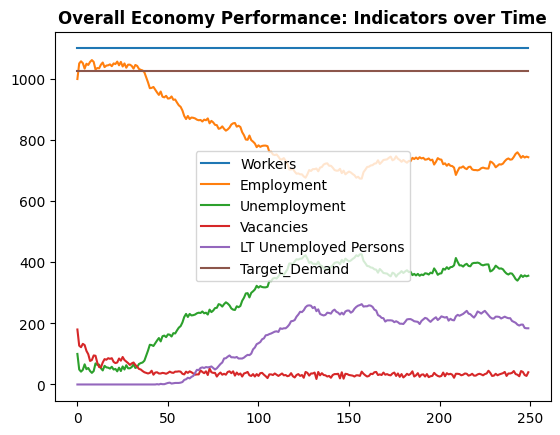

In [27]:
# Indicators in overall economy
totals = record1_f.loc[:,['Time', 'Workers','Employment', 'Unemployment', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']].groupby(['Time']).sum()
lgd = []
for column in totals[1:]:
    plt.plot(totals[column])
    lgd.append(column)
    plt.legend(list(lgd), loc="center", ncol=1)
plt.title("Overall Economy Performance: Indicators over Time", fontweight = 'bold')
if final:
    plt.savefig('../output/overall_economy_base.jpg', dpi = 300)
else:
    plt.show()
plt.close()

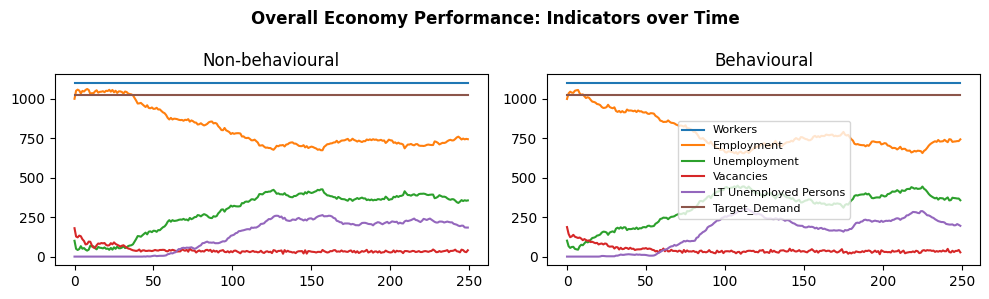

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

totals = record1_f.loc[:,['Time', 'Workers','Employment', 'Unemployment', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']].groupby(['Time']).sum()
lgd = []
for column in totals[1:]:
    ax1.plot(totals[column])
    lgd.append(column)
ax1.set_title("Non-behavioural")
    
totals = record1_t.loc[:,['Time', 'Workers','Employment', 'Unemployment', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']].groupby(['Time']).sum()
for column in totals[1:]:
    ax2.plot(totals[column])
ax2.set_title('Behavioural')

fig.suptitle("Overall Economy Performance: Indicators over Time", fontweight = 'bold')
plt.legend(list(lgd), loc="center", ncol=1, fontsize = 8)
fig.tight_layout()

if final:
    plt.savefig('../output/overall_economy_comparison_behav.jpg', dpi = 300)
else:
    plt.show()
plt.close()

#### Long-term unemployment rate and levels

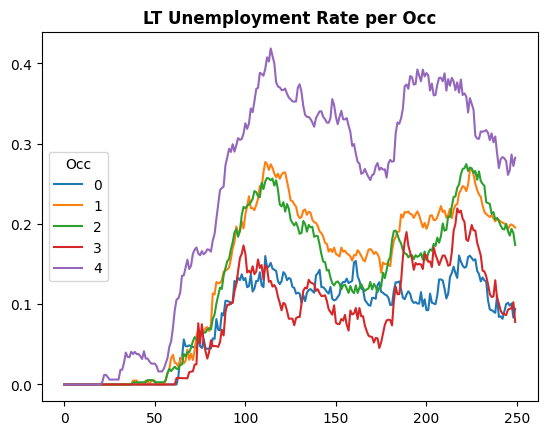

In [29]:
# LT Unemployed per occupation

ltue = record1_t.loc[:,['Time', 'Occupation_ID','Workers', 'LT Unemployed Persons']].groupby(['Time', 'Occupation_ID']).sum().reset_index()
ltue['LTUE Rate'] = ltue['LT Unemployed Persons'] / ltue['Workers']
lgd = []
for g in np.unique(ltue.Occupation_ID):
    temp = ltue[(ltue['Occupation_ID'] == g)][['LTUE Rate', 'Time']]
    plt.plot(temp['Time'], temp['LTUE Rate'])
    lgd.append(int(g))
plt.title("LT Unemployment Rate per Occ", fontweight = 'bold')
plt.legend(list(lgd), loc="center left", ncol=1, title = "Occ")
if final:
    plt.savefig('../output/ltuer_occ_base.jpg', dpi = 300)
else:
    plt.show()
plt.close(fig)

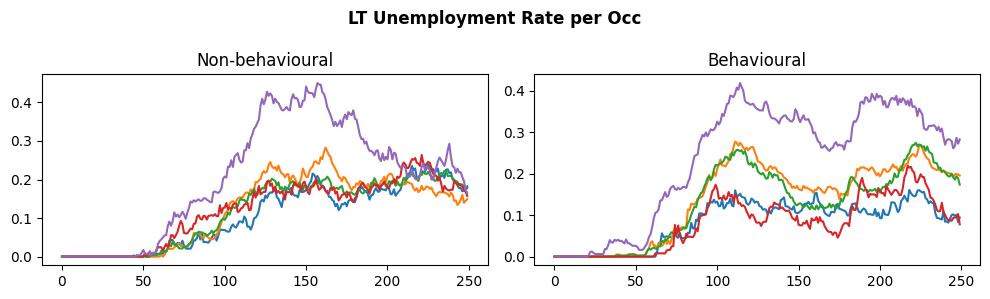

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ltue = record1_f.loc[:,['Time', 'Occupation_ID','Workers', 'LT Unemployed Persons']].groupby(['Time', 'Occupation_ID']).sum().reset_index()
ltue['LTUE Rate'] = ltue['LT Unemployed Persons'] / ltue['Workers']
lgd = []
for g in np.unique(ltue.Occupation_ID):
    temp = ltue[(ltue['Occupation_ID'] == g)][['LTUE Rate', 'Time']]
    ax1.plot(temp['Time'], temp['LTUE Rate'])
ax1.set_title("Non-behavioural")

ltue = record1_t.loc[:,['Time', 'Occupation_ID','Workers', 'LT Unemployed Persons']].groupby(['Time', 'Occupation_ID']).sum().reset_index()
ltue['LTUE Rate'] = ltue['LT Unemployed Persons'] / ltue['Workers']
lgd = []
for g in np.unique(ltue.Occupation_ID):
    temp = ltue[(ltue['Occupation_ID'] == g)][['LTUE Rate', 'Time']]
    ax2.plot(temp['Time'], temp['LTUE Rate'])
    lgd.append(int(g))
ax2.set_title('Behavioural')
fig.suptitle("LT Unemployment Rate per Occ", fontweight = 'bold')
fig.tight_layout()


if final:
    plt.savefig('../output/ltuer_occ_comparison_behav.jpg', dpi = 300)
else:
    plt.show()
plt.close()

#### Occupations: Employment, Unemployment, Worker, Vacancy, and Longterm Unemployed Levels

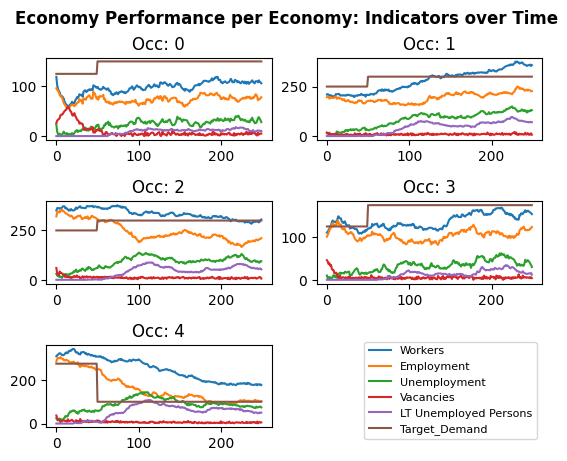

In [31]:
# Overall indicators per occupation
ids = np.unique(record1_t.Occupation_ID)
fig = plt.figure(constrained_layout = False)

occ_totals = record1_t.loc[:,['Time', 'Occupation_ID', 'Workers','Employment', 'Unemployment', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']]
for occ in ids:
    gtmp = occ_totals[(occ_totals['Occupation_ID'] == occ)].loc[:, ['Time', 'Workers', 'Employment', 'Unemployment', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']].groupby(['Time']).sum()
    # Indicators (workers, employment, etc)
    fig.add_subplot(3, 2, int(occ)+1, title = f'Occ: {int(occ)}')
    lgd = []
    for column in gtmp[1:]:
        plt.plot(gtmp[column])
        lgd.append(column)
    
fig.suptitle("Economy Performance per Economy: Indicators over Time", fontweight = 'bold')
fig.legend(list(lgd), bbox_to_anchor=(0.9, 0.3), ncols = 1, title_fontsize = "6", fontsize="8")
fig.subplots_adjust(wspace=0.2, hspace = 0.75)
if final:
    plt.savefig('../output/occ_perf_base.jpg', dpi = 300)
else:
    plt.show()
plt.close(fig)

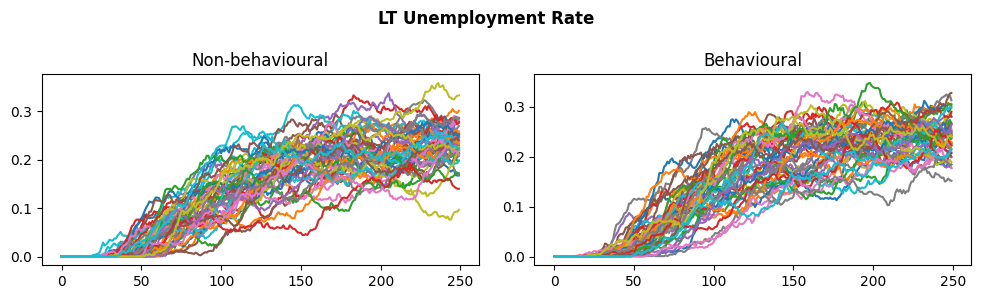

In [32]:
# fig = plt.figure(constrained_layout = False)
# ltue = sim_record.loc[:,['Sim', 'Time', 'Workers', 'LT Unemployed Persons']].groupby(['Time', 'Sim']).sum().reset_index()
# ltue['LTUE Rate'] = ltue['LT Unemployed Persons'] / ltue['Workers']
# lgd = []
# ltue
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ltue_tot = sim_record_f.loc[:,['Sim','Time', 'Workers', 'LT Unemployed Persons']].groupby(['Time', 'Sim']).sum().reset_index()
ltue_tot['LTUE Rate'] = ltue_tot['LT Unemployed Persons'] / ltue_tot['Workers']
for g in np.unique(ltue_tot.Sim):
    temp = ltue_tot[(ltue_tot['Sim'] == g)][['LTUE Rate', 'Time']]
    ax1.plot(temp['Time'], temp['LTUE Rate'])
ax1.set_title("Non-behavioural")
fig.suptitle("LT Unemployment Rate", fontweight = 'bold')


ltue_tot = sim_record_t.loc[:,['Sim','Time', 'Workers', 'LT Unemployed Persons']].groupby(['Time', 'Sim']).sum().reset_index()
ltue_tot['LTUE Rate'] = ltue_tot['LT Unemployed Persons'] / ltue_tot['Workers']
for g in np.unique(ltue_tot.Sim):
    temp = ltue_tot[(ltue_tot['Sim'] == g)][['LTUE Rate', 'Time']]
    ax2.plot(temp['Time'], temp['LTUE Rate'])
ax2.set_title("Behavioural")
fig.suptitle("LT Unemployment Rate", fontweight = 'bold')
fig.tight_layout()


if final:
    plt.savefig('../output/ltuer_sim_comparison_behav.jpg', dpi = 300)
else:
    plt.show()
plt.close()
# for i, ind in enumerate(['LTUE Rate']):
#     fig.add_subplot(1, 1, i+1) # , title=f'Indicator: {ind}'
#     for g in np.unique(ltue.Sim):
#         temp = ltue[(ltue['Sim'] == g)][[ind, 'Time']]
#         plt.plot(temp['Time'], temp[ind])
#         lgd.append(int(g))
# plt.suptitle("LT Unemployment Rate per Simulation", fontweight = 'bold')
# #plt.legend(list(lgd), loc="center left", ncol=1, title = "Occ")
# if final:
#     plt.savefig('../output/ltuer_occ_base.jpg', dpi = 300)
# else:
#     plt.show()
# plt.close(fig)